In [1]:
%matplotlib inline


# Compute MNE inverse solution on evoked data with a mixed source space

Create a mixed source space and compute an MNE inverse solution on an
evoked dataset.


In [2]:
# Author: Annalisa Pascarella <a.pascarella@iac.cnr.it>
#
# License: BSD (3-clause)

import os.path as op
import matplotlib.pyplot as plt

from nilearn import plotting

import mne
from mne.minimum_norm import make_inverse_operator, apply_inverse

# Set dir
data_path = mne.datasets.sample.data_path()
subject = 'sample'
data_dir = op.join(data_path, 'MEG', subject)
subjects_dir = op.join(data_path, 'subjects')
bem_dir = op.join(subjects_dir, subject, 'bem')

# Set file names
fname_mixed_src = op.join(bem_dir, '%s-oct-6-mixed-src.fif' % subject)
fname_aseg = op.join(subjects_dir, subject, 'mri', 'aseg.mgz')

fname_model = op.join(bem_dir, '%s-5120-bem.fif' % subject)
fname_bem = op.join(bem_dir, '%s-5120-bem-sol.fif' % subject)

fname_evoked = data_dir + '/sample_audvis-ave.fif'
fname_trans = data_dir + '/sample_audvis_raw-trans.fif'
fname_fwd = data_dir + '/sample_audvis-meg-oct-6-mixed-fwd.fif'
fname_cov = data_dir + '/sample_audvis-shrunk-cov.fif'

C:\ProgramData\Anaconda3\envs\mne\lib\site-packages\nilearn\datasets\__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Set up our source space
List substructures we are interested in. We select only the
sub structures we want to include in the source space:



In [3]:
labels_vol = ['Left-Amygdala',
              'Left-Thalamus-Proper',
              'Left-Cerebellum-Cortex',
              'Brain-Stem',
              'Right-Amygdala',
              'Right-Thalamus-Proper',
              'Right-Cerebellum-Cortex']

Get a surface-based source space, here with few source points for speed
in this demonstration, in general you should use oct6 spacing!



In [4]:
src = mne.setup_source_space(subject, spacing='oct5',
                             add_dist=False, subjects_dir=subjects_dir)

Setting up the source space with the following parameters:

SUBJECTS_DIR = C:\Users\WillKD\mne_data\MNE-sample-data\subjects
Subject      = sample
Surface      = white
Octahedron subdivision grade 5

>>> 1. Creating the source space...

Doing the octahedral vertex picking...
Loading C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\surf\lh.white...
Mapping lh sample -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\surf\lh.sphere...
Setting up the triangulation for the decimated surface...
loaded lh.white 1026/155407 selected to source space (oct = 5)

Loading C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\surf\rh.white...
Mapping rh sample -> oct (5) ...
    Triangle neighbors and vertex normals...
Loading geometry from C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\surf\rh.sphere...
Setting up the triangulation for the decimated surface...
loaded rh.white 1026/156866 se

Now we create a mixed src space by adding the volume regions specified in the
list labels_vol. First, read the aseg file and the source space bounds
using the inner skull surface (here using 10mm spacing to save time,
we recommend something smaller like 5.0 in actual analyses):



In [5]:
vol_src = mne.setup_volume_source_space(
    subject, mri=fname_aseg, pos=10.0, bem=fname_model,
    volume_label=labels_vol, subjects_dir=subjects_dir,
    add_interpolator=False,  # just for speed, usually this should be True
    verbose=True)

# Generate the mixed source space
src += vol_src
print(f"The source space contains {len(src)} spaces and "
      f"{sum(s['nuse'] for s in src)} vertices")

BEM              : C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-bem.fif
grid                  : 10.0 mm
mindist               : 5.0 mm
MRI volume            : C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\mri\aseg.mgz

Reading C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\mri\aseg.mgz...

Loaded inner skull from C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-bem.fif (2562 nodes)
Surface CM = (   0.7  -10.0   44.3) mm
Surface fits inside a sphere with radius   91.8 mm
Surface extent:
    x =  -66.7 ...   68.8 mm
    y =  -88.0 ...   79.0 mm
    z =  -44.5 ...  105.8 mm
Grid extent:
    x =  -70.0 ...   70.0 mm
    y =  -90.0 ...   80.0 mm
    z =  -50.0 ...  110.0 mm
4590 sources before omitting any.
2961 sources after omitting infeasible sources not within 0.0 - 91.8 mm.
Source spaces are in MRI coordinates.
Checking that the sources are inside the surface and at least    5.0 mm away (will take a few...)
    Sk

## View the source space



In [7]:
src.plot(subjects_dir=subjects_dir)

We could write the mixed source space with::

   >>> write_source_spaces(fname_mixed_src, src, overwrite=True)

We can also export source positions to nifti file and visualize it again:



Reading FreeSurfer lookup table


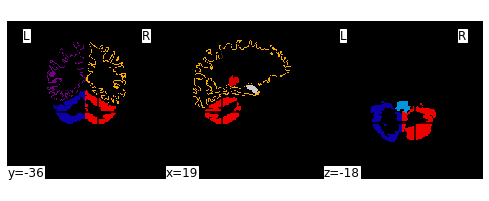

In [8]:
nii_fname = op.join(bem_dir, '%s-mixed-src.nii' % subject)
src.export_volume(nii_fname, mri_resolution=True, overwrite=True)
plotting.plot_img(nii_fname, cmap='nipy_spectral')

## Compute the fwd matrix



In [9]:
fwd = mne.make_forward_solution(
    fname_evoked, fname_trans, src, fname_bem,
    mindist=5.0,  # ignore sources<=5mm from innerskull
    meg=True, eeg=False, n_jobs=1)
del src  # save memory

leadfield = fwd['sol']['data']
print("Leadfield size : %d sensors x %d dipoles" % leadfield.shape)
print(f"The fwd source space contains {len(fwd['src'])} spaces and "
      f"{sum(s['nuse'] for s in fwd['src'])} vertices")

# Load data
condition = 'Left Auditory'
evoked = mne.read_evokeds(fname_evoked, condition=condition,
                          baseline=(None, 0))
noise_cov = mne.read_cov(fname_cov)

Source space          : <SourceSpaces: [<surface (lh), n_vertices=155407, n_used=1026>, <surface (rh), n_vertices=156866, n_used=1026>, <volume (Left-Amygdala), n_used=2>, <volume (Left-Thalamus-Proper), n_used=9>, <volume (Left-Cerebellum-Cortex), n_used=33>, <volume (Brain-Stem), n_used=21>, <volume (Right-Amygdala), n_used=1>, <volume (Right-Thalamus-Proper), n_used=7>, <volume (Right-Cerebellum-Cortex), n_used=44>] MRI (surface RAS) coords, subject 'sample', ~26.1 MB>
MRI -> head transform : C:\Users\WillKD\mne_data\MNE-sample-data\MEG\sample/sample_audvis_raw-trans.fif
Measurement data      : sample_audvis-ave.fif
Conductor model   : C:\Users\WillKD\mne_data\MNE-sample-data\subjects\sample\bem\sample-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 9 source spaces a total of 2169 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.999310  0.009985 -0.035787      -3.17 mm
     0.012759  

## Compute inverse solution



In [10]:
snr = 3.0            # use smaller SNR for raw data
inv_method = 'dSPM'  # sLORETA, MNE, dSPM
parc = 'aparc'       # the parcellation to use, e.g., 'aparc' 'aparc.a2009s'
loose = dict(surface=0.2, volume=1.)

lambda2 = 1.0 / snr ** 2

inverse_operator = make_inverse_operator(
    evoked.info, fwd, noise_cov, depth=None, loose=loose, verbose=True)
del fwd

stc = apply_inverse(evoked, inverse_operator, lambda2, inv_method,
                    pick_ori=None)
src = inverse_operator['src']

Converting forward solution to surface orientation
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 306 channels remain after picking
Selected 305 channels
Applying loose dipole orientations to surface source spaces: 0.2
Applying free  dipole orientations to volume  source spaces: 1.0
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 3.5e-13 (2.2e-16 eps * 305 dim * 5.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting sou

## Plot the mixed source estimate



In [15]:
initial_time = 0.1
stc_vec = apply_inverse(evoked, inverse_operator, lambda2, inv_method,
                        pick_ori='vector')
brain = stc_vec.plot(
    hemi='both', src=inverse_operator['src'], views='coronal',
    initial_time=initial_time, subjects_dir=subjects_dir)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Applying inverse operator to "Left Auditory"...
    Picked 305 channels from the data
    Computing inverse...
    Eigenleads need to be weighted ...
    Computing residual...
    Explained  59.0% variance
    dSPM...
[done]
Using control points [ 3.43101017  3.98225664 16.7504814 ]


## Plot the surface



In [13]:
brain = stc.surface().plot(initial_time=initial_time,
                           subjects_dir=subjects_dir)

Using control points [ 3.45409596  4.02821048 16.97219252]


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\viz\_brain\_brain.py", line 46, in safe_event
    return fun(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\viz\_brain\_brain.py", line 620, in _clean
    self.clear_glyphs()
  File "C:\ProgramData\Anaconda3\envs\mne\lib\site-packages\mne\viz\_brain\_brain.py", line 1516, in clear_glyphs
    assert sum(len(v) for v in self.picked_points.values()) == 0
AssertionError


## Plot the volume



Fixing initial time: 0.1 sec
Showing: t = 0.100 s, (-25.3, 19.0, -7.3) mm, [5, 10, 7] vox, 2045 vertex
Using control points [3.21567156 3.47889133 6.3983794 ]


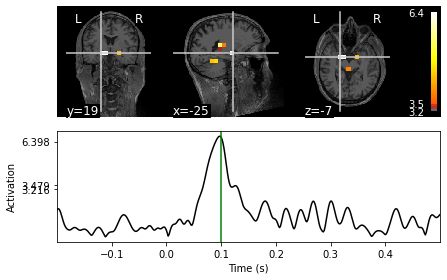

In [12]:
fig = stc.volume().plot(initial_time=initial_time, src=src,
                        subjects_dir=subjects_dir)

## Process labels
Average the source estimates within each label of the cortical parcellation
and each sub structure contained in the src space



In [ ]:
# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels_parc = mne.read_labels_from_annot(
    subject, parc=parc, subjects_dir=subjects_dir)

label_ts = mne.extract_label_time_course(
    [stc], labels_parc, src, mode='mean', allow_empty=True)

# plot the times series of 2 labels
fig, axes = plt.subplots(1)
axes.plot(1e3 * stc.times, label_ts[0][0, :], 'k', label='bankssts-lh')
axes.plot(1e3 * stc.times, label_ts[0][-1, :].T, 'r', label='Brain-stem')
axes.set(xlabel='Time (ms)', ylabel='MNE current (nAm)')
axes.legend()
mne.viz.tight_layout()

In [14]:
data_path

'C:\\Users\\WillKD\\mne_data\\MNE-sample-data'